# BEST MODEL
Paste parameters and workflow of best model here

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [3]:
# read in pickled features
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')

total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

df_sj.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month,ndvi_mean
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0.150606
1990-05-07,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0.157479
1990-05-14,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5,0.133315
1990-05-21,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,5,0.209286
1990-05-28,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,5,0.239235


## Train-Validation-Test Split
Because this is time-series data and the features set is dependent on the past, the train test split is very delicate. The validation and test feature set will actually draw from data in the past (rolling mean, std, etc.). Therefore, when creating the model, the entire dataset must be used. But I must be careful not to train the model on data from the 'future'.

In [4]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test

print(len(sj_train), len(sj_Xtrain), len(sj_ytrain))
print(len(sj_valid), len(sj_Xvalid), len(sj_yvalid))
print(len(sj_test), len(sj_Xtest))

675 675 675
261 261 261
260 260


In [5]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test

# check the lengths
print(len(iq_train), len(iq_Xtrain), len(iq_ytrain))
print(len(iq_valid), len(iq_Xvalid), len(iq_yvalid))
print(len(iq_test), len(iq_Xtest))

364 364 364
156 156 156
156 156


## SJ

In [6]:
print(len(pd.get_dummies(sj_Xtrain['month'], prefix='month')), len(sj_ytrain.values))
print(len(pd.get_dummies(sj_Xvalid['month'], prefix='month')), len(sj_yvalid.values))

675 675
261 261


In [7]:
pd.get_dummies(sj_Xtrain['month'], prefix='month').head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
week_start_date,,,,,,,,,,,,
1990-04-30,0,0,0,1,0,0,0,0,0,0,0,0
1990-05-07,0,0,0,0,1,0,0,0,0,0,0,0
1990-05-14,0,0,0,0,1,0,0,0,0,0,0,0
1990-05-21,0,0,0,0,1,0,0,0,0,0,0,0
1990-05-28,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
# sj monthly trend

lr_sj = LinearRegression()
X = pd.get_dummies(sj_Xtrain['month'], prefix='month')
y = sj_ytrain.values

print(X.head())


                 month_1  month_2  month_3  month_4  month_5  month_6  \
week_start_date                                                         
1990-04-30             0        0        0        1        0        0   
1990-05-07             0        0        0        0        1        0   
1990-05-14             0        0        0        0        1        0   
1990-05-21             0        0        0        0        1        0   
1990-05-28             0        0        0        0        1        0   

                 month_7  month_8  month_9  month_10  month_11  month_12  
week_start_date                                                           
1990-04-30             0        0        0         0         0         0  
1990-05-07             0        0        0         0         0         0  
1990-05-14             0        0        0         0         0         0  
1990-05-21             0        0        0         0         0         0  
1990-05-28             0        0     

In [9]:
lr_sj.fit(X, y)
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train

In [10]:
pd.Series(lr_sj.predict(X))

0      11.7500
1      13.6875
2      13.6875
3      13.6875
4      13.6875
5      18.1250
6      18.1250
7      18.1250
8      18.1250
9      28.6250
10     28.6250
11     28.6250
12     28.6250
13     28.6250
14     49.2500
15     49.2500
16     49.2500
17     49.2500
18     56.5625
19     56.5625
20     56.5625
21     56.5625
22     80.9375
23     80.9375
24     80.9375
25     80.9375
26     80.9375
27     75.6250
28     75.6250
29     75.6250
        ...   
645    56.5625
646    80.9375
647    80.9375
648    80.9375
649    80.9375
650    80.9375
651    75.6250
652    75.6250
653    75.6250
654    75.6250
655    52.1250
656    52.1250
657    52.1250
658    52.1250
659    36.7500
660    36.7500
661    36.7500
662    36.7500
663    36.7500
664    24.0625
665    24.0625
666    24.0625
667    24.0625
668    17.3125
669    17.3125
670    17.3125
671    17.3125
672    11.7500
673    11.7500
674    11.7500
Length: 675, dtype: float64

In [11]:
monthly_trend_train

0      11.750000
1      12.718750
2      13.041667
3      13.687500
4      13.687500
5      15.166667
6      16.645833
7      18.125000
8      18.125000
9      21.625000
10     25.125000
11     28.625000
12     28.625000
13     28.625000
14     35.500000
15     42.375000
16     49.250000
17     49.250000
18     51.687500
19     54.125000
20     56.562500
21     56.562500
22     64.687500
23     72.812500
24     80.937500
25     80.937500
26     80.937500
27     79.166667
28     77.395833
29     75.625000
         ...    
645    56.562500
646    64.687500
647    72.812500
648    80.937500
649    80.937500
650    80.937500
651    79.166667
652    77.395833
653    75.625000
654    75.625000
655    67.791667
656    59.958333
657    52.125000
658    52.125000
659    47.000000
660    41.875000
661    36.750000
662    36.750000
663    36.750000
664    32.520833
665    28.291667
666    24.062500
667    24.062500
668    21.812500
669    19.562500
670    17.312500
671    17.312500
672    15.4583

In [12]:
# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(sj_Xvalid['month'], prefix='month')
ytest = sj_yvalid.values
# smoothing the predicted values curve
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid


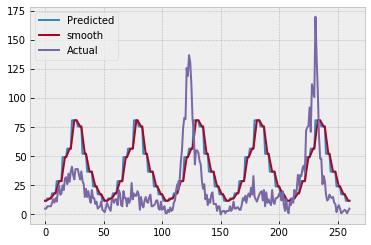

24.395833333333332
25.20522030651341


In [13]:
# plot
plt.plot(lr_sj.predict(Xtest), label='Predicted')
plt.plot(monthly_trend_valid, label='smooth')
plt.plot(ytest, label='Actual')
plt.legend()
plt.show()

print(mean_absolute_error(lr_sj.predict(Xtest), ytest))
print(mean_absolute_error(monthly_trend_valid, ytest))

-16.12236590038314
675 261


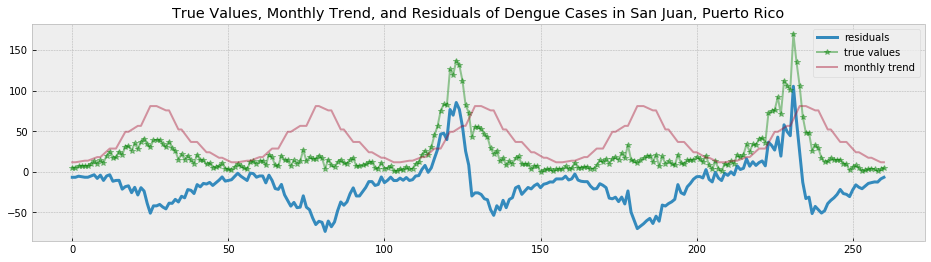

In [14]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(sj_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in San Juan, Puerto Rico')
plt.legend()
print(np.mean(sj_residuals_test))

print(len(sj_residuals_train), len(sj_residuals_test))

## PREDICT THE BLUE!!!

## Test on valid from grid search results
use values from 3 tables above

In [15]:
# munge data

# max roll back set to 59

# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[60:675]

Xtrain_means1.head()

week_start_date
1991-06-25    26.900824
1991-07-02    26.901648
1991-07-09    26.918132
1991-07-16    26.931044
1991-07-23    26.928846
Name: station_avg_temp_c, dtype: float64

In [16]:
# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_train[60:]

Xtrain.head()


,station_avg_temp_c
week_start_date,
1991-06-25,26.900824
1991-07-02,26.901648
1991-07-09,26.918132
1991-07-16,26.931044
1991-07-23,26.928846


615 615
201 201
25.48995970139475
-0.10823488503472456


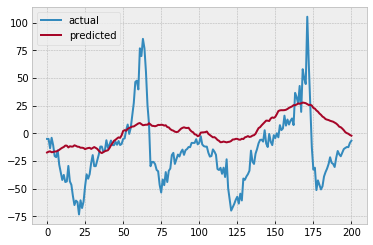

In [17]:
print(len(Xtrain), len(ytrain))

# rolling means df
Xvalid_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = sj_residuals_test[60:]

print(len(Xvalid), len(yvalid))

# fit on model, predict
lr_sj_residual = LinearRegression()
lr_sj_residual.fit(Xtrain, ytrain)

sj_valid_preds = lr_sj_residual.predict(Xvalid)

print(mean_absolute_error(sj_valid_preds, yvalid))
print(lr_sj_residual.score(Xvalid, yvalid))
plt.plot(yvalid.values, label='actual')
plt.plot(sj_valid_preds, label='predicted')
plt.legend()

### Notes:

* I will slowly add more features to this graph

## IQ

Do the same as I did for SJ above, but to see which IQ features explain the variance in the residuals.

In [18]:
print(len(pd.get_dummies(iq_Xtrain['month'], prefix='month')), len(iq_ytrain.values))
print(len(pd.get_dummies(iq_Xvalid['month'], prefix='month')), len(iq_yvalid.values))

364 364
156 156


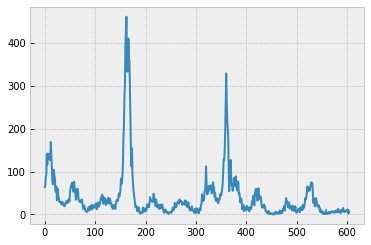

In [19]:
plt.plot(y[70:])

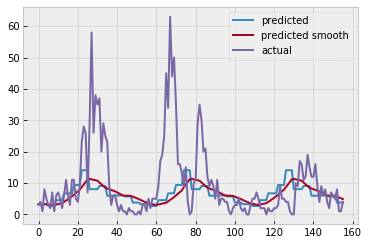

7.050430689102564
6.92185751170126


In [20]:
# iq monthly trend

lr_iq = LinearRegression()
X = pd.get_dummies(iq_Xtrain['month'], prefix='month')
y = iq_ytrain.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(9, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_Xvalid['month'], prefix='month')
ytest = iq_yvalid.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(9, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest), label='predicted')
plt.plot(monthly_trend_valid, label='predicted smooth')
plt.plot(ytest, label='actual')
plt.legend()
plt.show()

print(mean_absolute_error(lr_iq.predict(Xtest), ytest))
print(mean_absolute_error(monthly_trend_valid, ytest))

3.4263996998371997


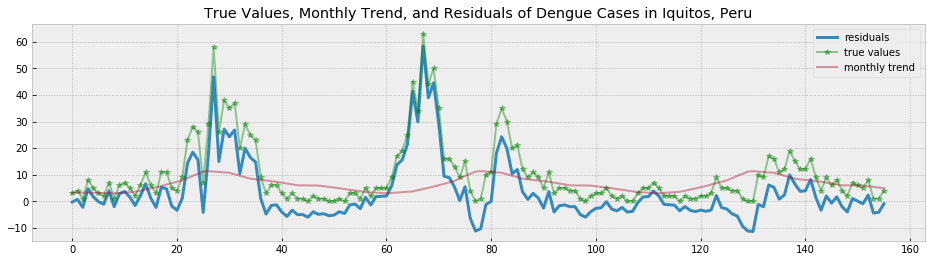

In [21]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(iq_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in Iquitos, Peru')
plt.legend()
print(np.mean(iq_residuals_test))

## PREDICT THE BLUE!!!
# Note: the monthly predictions for iq are pretty bad over the validation set...

## predict the residuals based on rolling weather features

In [22]:
len(Xtrain)
len(ytrain)

615

304 304
96 96
0.05670430593191833
6.957011058670287


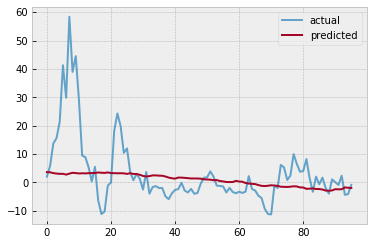

In [23]:
# rolling mean of feature to predict residuals

# munge data

# max roll back set to 59

# set up training data
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_train[60:]

print(len(Xtrain), len(ytrain))

# set up validation data
# rolling means df
Xvalid_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[364:520]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = iq_residuals_test[60:]

print(len(Xvalid), len(yvalid))

# model it!

lr_iq_resids = LinearRegression()
lr_iq_resids.fit(Xtrain, ytrain)

iq_valid_preds = lr_iq_resids.predict(Xvalid)

# plot iq residual predictions
plt.plot(yvalid.values, alpha = .75, label='actual')
plt.plot(iq_valid_preds, label='predicted')
plt.legend()

print(lr_iq_resids.score(Xvalid, yvalid))
print(mean_absolute_error(iq_valid_preds, yvalid))

### Notes:

* IQ resiuduals is much more erratic and harder to predict
* Tweak these features more

## USE TEST DATA, MAKE CSV OF SUBMISSIONS

Need to use full dataset (train + test) because values depend on previous weather data

In [24]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['station_avg_temp_c']].rolling(window = 55).mean())
# temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

# predicts
sj_full_preds = lr_sj_full.predict(Xtest[55:])
sj_submit_preds = sj_full_preds[-260:]

25.72233257661748


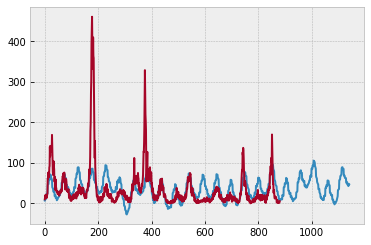

In [25]:
plt.plot(sj_full_preds)
plt.plot(cases_sj.values[55:])
print(mean_absolute_error(sj_full_preds[:-260], cases_sj.values[55:]))

In [26]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_nw']].rolling(window = 68).mean())
# temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = lr_iq_full.predict(Xtest[68:])
iq_submit_preds = iq_full_preds[-156:]

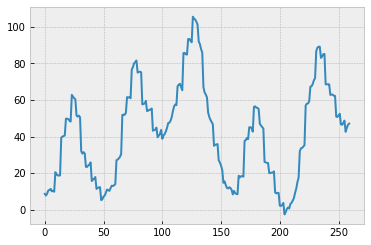

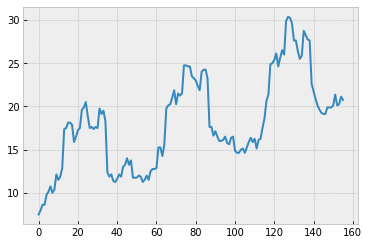

In [27]:
plt.plot(sj_submit_preds)
plt.show()
plt.plot(iq_submit_preds)
plt.show()

In [28]:
total_preds = list(sj_submit_preds) + list(iq_submit_preds)

### make csv

In [29]:
# submission
submission_format = pd.read_csv('./datasets/submission_format.csv')

In [30]:
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [31]:
# Save to CSV, use current date
# submission_format.to_csv('submissions/dengue_submission_9_12_17v1.csv', index=False)

## Make predictions v2
Predict the residuals, then add them to the monthly trend

### San Juan

In [69]:
# get monthly trend of whole test df
lr_sj_month = LinearRegression()
X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

lr_sj_month.fit(X_months, y)
monthly_trend = pd.Series(lr_sj_month.predict(X_months)).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[60:936]
# Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[60:936]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[936:]
Xtest_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_sj_resid = LinearRegression()
lr_sj_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
# make predictions on monthly data and residual data

# from train data predicted "cases" w.r.t. month - rolling mean (monthly trend)
sj_monthly_preds = pd.Series(lr_sj_month.predict(Xtest_months)).rolling(3, min_periods=1).mean()

# from test data pred predicted residual w.r.t. station_avg_temp_c
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)

# print(pd.Series(sj_resid_preds + sj_monthly_preds).head())
# useless (elixir)
# sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
# print(sj_cases_pred.head())

sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))

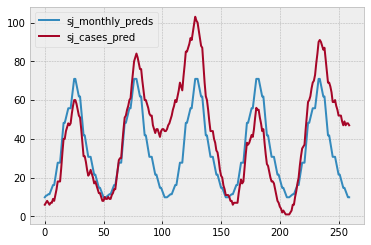

In [71]:
# plt.plot(sj_resid_preds)
plt.plot(sj_monthly_preds, label='sj_monthly_preds')
plt.plot(sj_cases_pred, label='sj_cases_pred')
plt.legend()

Text(0,0.5,'Cases')

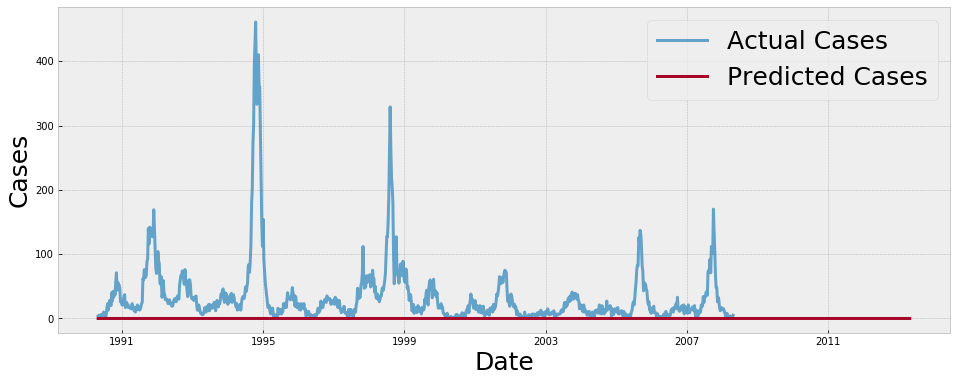

In [73]:
### make plot of best model predictions and actual cases over all time period for sj

# monthly trend
sj_month_preds = lr_sj_month.predict(pd.get_dummies(df_sj['month'], prefix='month'))
# predicted residuals
weather1 = df_sj[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_sj[['reanalysis_dew_point_temp_k']].rolling(window=53, min_periods=1).mean()
weather_all = pd.concat([weather2], axis = 1)
sj_resid_predicts = lr_sj_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(sj_month_preds + sj_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_sj.index[:936], cases_sj, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_sj.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

### Iquitos

In [41]:
len(cases_iq)

520

In [77]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:520]
Xtrain_means3 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53).mean()[60:520] # elixir

# combine all dfs
Xtrain = pd.concat([Xtrain_means3], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[520:]
Xtest_means3 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53).mean()[520:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means3], axis = 1)

# fit on model
lr_iq_resid = LinearRegression()
lr_iq_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

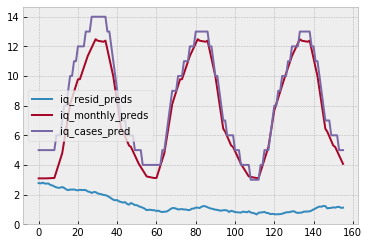

In [79]:
plt.plot(iq_resid_preds, label='iq_resid_preds')
plt.plot(iq_monthly_preds, label='iq_monthly_preds')
plt.plot(iq_cases_pred, label='iq_cases_pred')
plt.legend()

Text(0,0.5,'Cases')

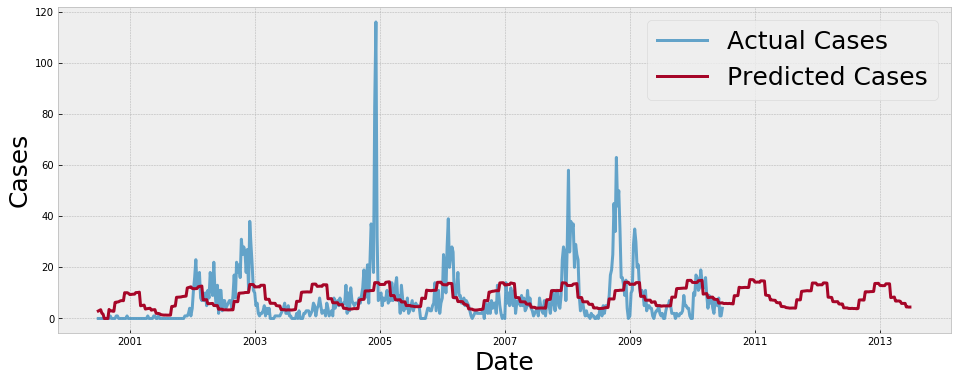

In [80]:
### make plot of best model predictions and actual cases over all time period for iq

# monthly trend
iq_month_preds = lr_iq_month.predict(pd.get_dummies(df_iq['month'], prefix='month'))
# predicted residuals
weather1 = df_iq[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_iq[['ndvi_se']].rolling(window=10, min_periods=1).mean()
weather3 = df_iq[['reanalysis_specific_humidity_g_per_kg']].rolling(window=53, min_periods=1).mean()
weather_all = pd.concat([weather3], axis = 1)
iq_resid_predicts = lr_iq_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(iq_month_preds + iq_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_iq.index[:520], cases_iq, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_iq.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

### make csv

In [81]:
total_preds = list(sj_cases_pred) + list(iq_cases_pred)

In [82]:
# submission
submission_format = pd.read_csv('./datasets/submission_format.csv')

In [83]:
submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [84]:
# Save to CSV, use current date
submission_format.to_csv('submissions/dengue_submission_July_17_18v2.csv', index=False)

In [85]:
submission_format.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,7
2,sj,2008,20,8
3,sj,2008,21,7
4,sj,2008,22,6


### Submitted MAEs!!!!
* monthly trend and mean `station_avg_temp_c` with window = 52 was 20.7764
* monthly trend and mean `station_avg_temp_c` with window = 52 and std window = 8 was 20.7981
* monthly trend and mean `station_avg_temp_c` and `precipitation_amt_mm` with window = 52 and std window = 8 was 24.1274
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and iq used 'ndvi_nw' with window = 68 was 23.5697
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and `ndvi_se` with window = 10 and iq used 'ndvi_nw' with window = 68 was 21.337
* Next steps: use other rolling features (and std? and shifted? and exponentially weighted mean?)